In [1]:
# standard libraries
import pandas as pd
import numpy as np
#import re
import os
from IPython.display import Image
from abc import ABC, abstractmethod
import time
#import sklearn
#import time

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
from IPython.display import clear_output
import xgboost

# data pre-processing
from scipy.io import arff
#from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.impute._base import _BaseImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# prediction models
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm._base import BaseSVC 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

In [2]:
from os import listdir
from os.path import isfile, join

class FilePathManager:
    def __init__(self, local_dir: str):
        self.local_dir = local_dir
    
    def retrieve_full_path(self):
        return os.getcwd()+'/'+self.local_dir

In [3]:
class Loader:
    df = pd.DataFrame()
    
    @abstractmethod
    def load_data(self, file_name):
        pass
    
    @abstractmethod
    def get_df(self):
        pass
    
    def size(self):
        return len(self.df)
        

In [4]:
from typing import Callable

 
class CSVLoader(Loader):
    def __init__(self, file_path_manager: FilePathManager):
        self.file_path_manager = file_path_manager
        
    def load_data(self, _prepare_data: Callable[[pd.DataFrame], pd.DataFrame] = None):
        self.df = pd.read_csv(self.file_path_manager.retrieve_full_path())
        if _prepare_data:
            self.df = _prepare_data(self.df)
    
    def get_df(self):
        return self.df;
    
    def size(self):
        return len(self.df)  

In [5]:
def clean_data(df):
    data = df.copy()
    data.loc[ df['Action']!='allow', 'Action']='not allow'
    depandent = data['Action']
    depandent = (depandent=='allow').astype(int)
    data['Action']= depandent
    return data

In [6]:
loader = CSVLoader(FilePathManager('log2.csv'))
loader.load_data(clean_data)

In [7]:
loader.get_df()['Action'].value_counts()

1    37640
0    27892
Name: Action, dtype: int64

In [8]:
class BaseImputer:
    @abstractmethod
    def fit(self, X, y=None):
        pass
    
    @abstractmethod
    def transform(self, X):
        pass

class BaseModel:
    @abstractmethod
    def fit(self, X, y, sample_weight=None):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass

In [138]:
class Modeling:
    _X_train_fitted = None
    _X_test_fitted = None
    _y_train = None
    _y_test = None
    _y_preds = None
    
    def __init__(self, data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, scaler = None):
        self._data = data
        self._target_name = target_name
        self._shuffle_splitter = shuffle_splitter
        self._imputer = imputer
        self._model = model
        self._X, self._y = self._split_data()
        self._scaler = scaler
        
    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y

    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, model):
        self._model = model
     
    @property
    def X_train(self):
        return self._X_train_fitted
    
    @property
    def X_test(self):
        return self._X_test_fitted
    
    @property
    def y_train(self):
        return self._y_train
    
    @property
    def y_test(self):
        return self._y_test
    
    @property
    def y_preds(self):
        return self._y_preds
    
    def _split_data(self):
        X = self._data.copy()
        return X.drop([self._target_name], axis=1) , X[self._target_name]
    
    def _shuffle_split(self):
        X = self.X
        y = self.y
        for train_index, test_index in self._shuffle_splitter.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
    def _fit_imputer(self, train):
        if self._imputer is not None:
            self._imputer.fit(train)
    
    def _fit_scaler(self, train):
        if self._scaler is not None:
            self._scaler.fit(train)
    
    def _impute_data(self, X: pd.DataFrame):
        if self._imputer is not None:
            return pd.DataFrame(self._imputer.transform(X), columns = self.X.columns, index = X.index)
        return X
    
    def _scale_data(self, X: pd.DataFrame):
        if self._scaler is not None:
            X = pd.DataFrame(self._scaler.transform(X), columns = self._X.columns)
        return X
    
    def prepare(self):
        X_train, X_test, y_train, y_test = self._shuffle_split()   
        self._fit_imputer(X_train)
        X_train = self._impute_data(X_train)
        X_test = self._impute_data(X_test)
        self._fit_scaler(X_train)
        self._X_train_fitted = self._scale_data(X_train)
        self._X_test_fitted = self._scale_data(X_test)
        self._y_train = y_train
        self._y_test = y_test
        
    def prepare_and_train(self):
        self.prepare()
        return self.train()
        
    def train(self):
        self._model.fit(self.X_train, self.y_train)
        self._y_preds = self._model.predict(self.X_train)
        
        return self.metrics(self.y_train, self.y_preds)
        
    def test(self):
        return self.metrics(self.y_test, self._model.predict(self.X_test))
       
    @abstractmethod
    def metrics(self, y_true = None, y_pred = None):
        pass
        

In [139]:
class ClassificationModeling(Modeling):
    def __init__(self, 
                 data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, 
                 scaler = None, 
                 beta: int = 1, 
                 classification: str = 'binary'):
        super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler)
        self.beta = beta
        self.classification = classification
        
    @abstractmethod
    def metrics(self, y_true = None, y_pred = None):
        pass
        

In [140]:
from typing import Type, TypeVar

class SVMClassificationModeling(ClassificationModeling):
    TSVC = TypeVar("TSVC", bound=BaseSVC)
    all_models = [];
    
    def __init__(self, 
             data: pd.DataFrame, 
             target_name: str, 
             shuffle_splitter: BaseShuffleSplit, 
             imputer: BaseImputer, 
             model: BaseModel, 
             scaler = None, 
             beta: int = 1, 
             classification: str = 'binary'):
         super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler, beta, classification)
        
            
    def parameter_tuning(self, params, class_to_instantiate: Type[TSVC]):
        list_of_models = []
        combination = []
        params_base = {}
        output = []
        for key, value in params.items():
            if isinstance(value, list):
                combination.append((key,value))
            else:
                params_base[key]=value
              
        result = SVMClassificationModeling.get_combinations(combination)

        for r in result:
            list_of_models.append(class_to_instantiate(**{**params_base, **r}))
            
        for a_model in list_of_models:
            self.model = a_model
            startTrain = time.time()
            train_metrics = self.train()
            endTrain = time.time()
            test_metrics = self.test()
            endTest = time.time()
            train_time = endTrain - startTrain
            test_time = endTest - endTrain
            output.append({'model': a_model, 'train_metrics': {**train_metrics,**{'elapsed_time':train_time}}, 'test_metrics': {**test_metrics,**{'elapsed_time':test_time}}})
        self.all_models = output
        return output
        
    def find_best_model(self):
        max_accuracy = self.all_models[0]['test_metrics']['accuracy']
        location = 0
        for indx, output_metrics in enumerate(self.all_models):
            if max_accuracy < output_metrics['test_metrics']['accuracy']:
                max_accuracy = output_metrics['test_metrics']['accuracy']
                location = indx
            elif max_accuracy == output_metrics['test_metrics']['accuracy']:
                if output_metrics['test_metrics']['elapsed_time'] < self.all_models[location]['test_metrics']['elapsed_time']:
                    location = indx
                
        return self.all_models[location]
    
    @staticmethod
    def get_combinations(tuples):
        length = len(tuples)
        if length > 1:
            total_params = []
            tuple_copy = tuples.copy()
            a_tuple = tuple_copy.pop(0)
            params_list = SVMClassificationModeling.get_combinations(tuple_copy)
            for value in a_tuple[1]:
                for a_params in params_list:
                    temp = { a_tuple[0]: value}
                    total_params.append({**temp, **a_params})
            return total_params
        else:
            params_list = []
            a_tuple =  tuples[0]
            for value in a_tuple[1]:
                temp = {}
                temp[a_tuple[0]] = value
                params_list.append(temp)
            return params_list
            
    
    def metrics(self, y_true = None, y_pred = None):
        if y_true is None and y_pred is None:
            y_true = self.y_train
            y_pred = self.y_preds       
        return {'matrix': confusion_matrix(y_true, y_pred), 
                'accuracy': round(accuracy_score(y_true, y_pred), 5), 
                'precision': precision_score(y_true, y_pred, average=self.classification), 
                'recall': recall_score(y_true, y_pred, average=self.classification),
                'f1': f1_score(y_true, y_pred)}

In [12]:
classifier = SVMClassificationModeling(loader.get_df(),'Action',
                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                           None,
                           None,
                           StandardScaler(), beta=2)

In [13]:
classifier.prepare()

In [14]:
results = classifier.parameter_tuning({
    "max_iter":1000,
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
},SGDClassifier)

In [115]:
results

[{'model': SGDClassifier(),
  'train_metrics': {'matrix': array([[19507,    17],
          [   92, 26256]], dtype=int64),
   'accuracy': 0.99762,
   'precision': 0.9993529478932744,
   'recall': 0.9965082738727797,
   'f1': 0.9979285836453128,
   'elapsed_time': 0.271787166595459},
  'test_metrics': {'matrix': array([[ 8361,     7],
          [   35, 11257]], dtype=int64),
   'accuracy': 0.99786,
   'precision': 0.9993785511363636,
   'recall': 0.996900460503011,
   'f1': 0.9981379677247738,
   'elapsed_time': 0.05285763740539551}},
 {'model': SGDClassifier(penalty='l1'),
  'train_metrics': {'matrix': array([[19507,    17],
          [   64, 26284]], dtype=int64),
   'accuracy': 0.99823,
   'precision': 0.99935363674385,
   'recall': 0.9975709731288902,
   'f1': 0.9984615092404414,
   'elapsed_time': 0.290330171585083},
  'test_metrics': {'matrix': array([[ 8361,     7],
          [   23, 11269]], dtype=int64),
   'accuracy': 0.99847,
   'precision': 0.9993792124866974,
   'recall': 0.

In [116]:
classifier.find_best_model()

{'model': SGDClassifier(loss='modified_huber', penalty='l1'),
 'train_metrics': {'matrix': array([[19507,    17],
         [   30, 26318]], dtype=int64),
  'accuracy': 0.99898,
  'precision': 0.9993544712359977,
  'recall': 0.9988613936541673,
  'f1': 0.9991078716094376,
  'elapsed_time': 0.6954727172851562},
 'test_metrics': {'matrix': array([[ 8361,     7],
         [   13, 11279]], dtype=int64),
  'accuracy': 0.99898,
  'precision': 0.9993797625376573,
  'recall': 0.998848742472547,
  'f1': 0.9991141819470281,
  'elapsed_time': 0.07978558540344238}}

In [141]:
final_classifier = SVMClassificationModeling(loader.get_df(),'Action',
                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                           None,
                           SGDClassifier(loss='modified_huber', penalty='l1'),
                           StandardScaler(), beta=2)

In [143]:
final_classifier.prepare_and_train()
final_classifier.model.coef_

array([[-5.16829598e-02, -9.24152769e-01,  1.80223563e-01,
         1.51425633e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.24138172e+02,
         0.00000000e+00,  0.00000000e+00]])

In [144]:
final_classifier.X.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received',
       'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received'],
      dtype='object')

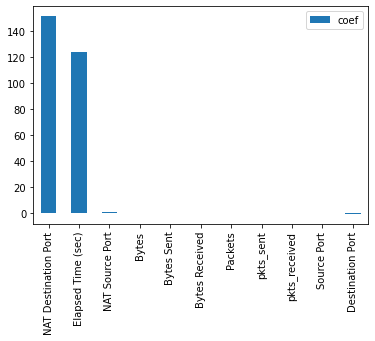

In [146]:
weights = pd.DataFrame(final_classifier.model.coef_[0], final_classifier.X.columns, columns=['coef']).sort_values('coef', ascending=False)
weights.plot(kind='bar')
plt.show()